### Evaluation CPSS

In [1]:
### Load libraries
import itertools
import features
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dataloader
import pitchspace
import mir_eval

def computeChromaData(dset,track_id,time_interval,source_separation="none"):
    dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata",source_separation)
    audiopath, annotationpath = dataset[track_id] 
    sig = utils.loadAudiofile(audiopath, offset=time_interval[0], duration=time_interval[1]-time_interval[0])
    gt = utils.loadChordAnnotations(annotationpath,time_interval)
    chroma,pitchgram,pitchgram_cqt = features.crpChroma(sig)
    t_chroma = utils.timeVector(chroma.shape[1],t_start=time_interval[0],t_stop=time_interval[1],hop_length=2048)
    return sig,gt,t_chroma,chroma,pitchgram,pitchgram_cqt

def plotData(sig,gt,t_chroma,chroma,pitchgram,hcdf,stable_regions,time_interval):
    rms = features.computeRMS(sig)
    t_audio = utils.timeVector(sig.shape[0],t_start=time_interval[0],t_stop=time_interval[1],hop_length=1)
    fig,(ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1,height_ratios=(1,5,10,5,5),figsize=(8,6))
    utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
    ax0.set_title('Annotations',fontsize=10)
    ax1.plot(t_audio,sig)
    ax1.set_ylabel("Amplitude")
    ax1.grid("on")
    ax12 = ax1.twinx()
    ax12.plot(t_chroma,rms,'-',color="r")
    ax12.set_ylabel("RMS in dB", color='red')
    ax12.tick_params('y', colors='red')
    # plot cqt
    utils.plotCQT(ax2,t_chroma,pitchgram,time_interval)
    ax2.set_ylim(100,1000)
    # plot chroma
    utils.plotChromagram(ax3,t_chroma,chroma,time_interval)

    ax4.plot(t_chroma,hcdf)
    for x,y in itertools.pairwise(stable_regions):
        x_i0,x_i1 = x 
        y_i0,y_i1 = y
        rect = patches.Rectangle((t_chroma[x_i1],-0.5),t_chroma[y_i0] - t_chroma[x_i1],12,facecolor="k",alpha=0.1,edgecolor="k")
        ax3.add_patch(rect)
        ax3.add_artist(rect)

    for indices in stable_regions:
        ax4.hlines(1,t_chroma[indices[0]],t_chroma[indices[1]],'green')
        ax4.vlines([t_chroma[indices[0]],t_chroma[indices[1]]],[0,0],[1,1],'green')
    ax4.hlines(0.3,time_interval[0],time_interval[1],'k',linestyle="--")

    ax4.set_ylabel("HCDF")
    ax4.set_ylim(0,2)
    ax4.set_xlim(time_interval)
    ax4.grid("on")
    xticks = np.linspace(time_interval[0],time_interval[1],num=11)
    ax4.set_xticks(xticks)
    ax4.set_xlabel("Time in s")
    ax4.legend(["hcdf","gate"],loc=1,ncols=2)
    ax0.set_yticks([])
    for ax in (ax0,ax1,ax2,ax3):
        ax.set_xlim(time_interval)
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
        ax.set_xlabel("")

    fig.tight_layout(pad=0.1)


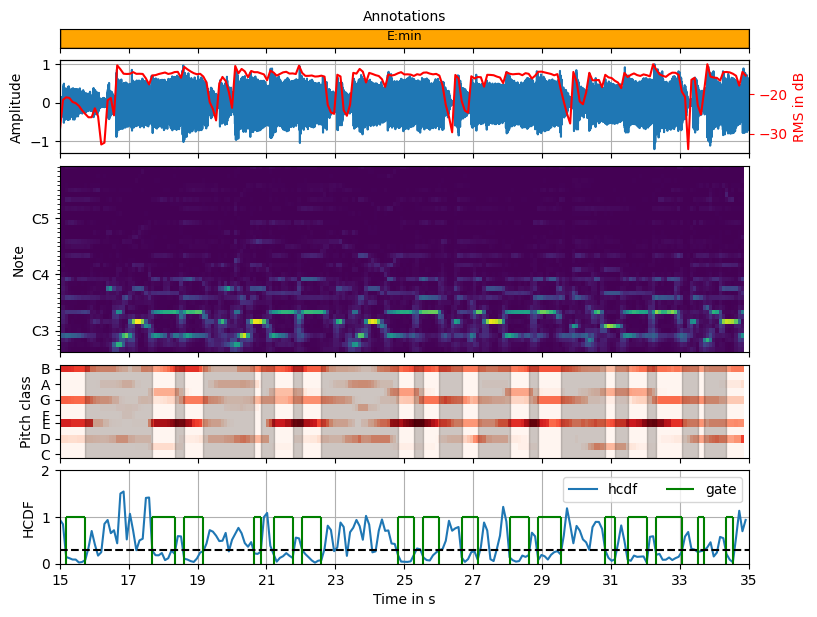

In [4]:
dset = "rwc_pop"  # beatles   "RM-P012"
track_id = "RM-P009" 
time_interval = (15,35)
sig, gt, t_chroma, chroma, pitchgram,pitchgram_cqt = computeChromaData(dset,track_id,time_interval,"both")

## compute stable chroma regions
classifier = pitchspace.CPSS_Classifier("/home/max/ET-TI/Masterarbeit/chord-recognition/models/cpss/cpss_sevenths.npy",alphabet="sevenths")
stable_regions, hcdf = classifier.computeStableRegions(chroma)

# prefilter
chroma = features.applyPrefilter(t_chroma,chroma,"median",N=7)

plotData(sig,gt,t_chroma, chroma,pitchgram_cqt,hcdf,stable_regions,time_interval)

CPSS
Majmin: WCSR=79.2% , Q=14.8%
Sevenths: WCSR=65.7% , Q=14.8%
Templates
Majmin: WCSR=82.9% , Q=45.4%
Sevenths: WCSR=75.0% , Q=45.4%


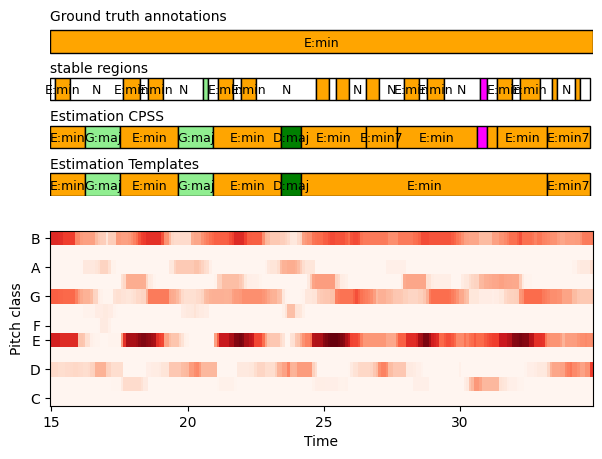

In [6]:
## key estimation
use_key_estimation = True
use_average = True

def postfilter(estimation_matrix):
    # postfiltering using HMM 
    # load pretrained state transition probability matrix or use uniform state transition
    model_path = "/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/sevenths_30.npy"
    A = np.load(model_path,allow_pickle=True)
    # compute quasi-normalized likelihood matrix   
    B_O = estimation_matrix / (np.sum(estimation_matrix,axis=0) + np.finfo(float).tiny) 
    C = np.ones((len(labels,))) * 1/len(labels)   # initial state probability matrix
    smoothed_estimation_matrix, _, _, _ = features.viterbi_log_likelihood(A, C, B_O)
    return smoothed_estimation_matrix

# pattern matching 
templates,labels = utils.createChordTemplates("sevenths")
correlation = features.computeCorrelation(chroma,templates,inner_product=False)
correlation_templates = np.copy(correlation)
estimation_matrix = np.zeros((len(classifier._labels), t_chroma.shape[0]),dtype=float)
estimation_matrix[-1,:] = 1.0
cpss_labels = []
cpss_intervals = []
# classify stable regions witch tonal pitch space
for (i0, i1) in stable_regions:
    if use_key_estimation:
        # find tonal center of stable regions with ~8 seconds context
        i_a = np.maximum(0,i0-40)
        i_b = np.minimum(chroma.shape[1],i1+40)
        temp = np.average(chroma[:, np.maximum(0,i0-40):np.minimum(chroma.shape[1],i1+40)], axis=1)
        key_index = classifier.selectKey(temp)
    else:
        key_index = None
    if use_average:
        # classify an average chromavector
        chroma_avg = np.average(chroma[:, i0:i1], axis=1)
        chroma_avg = chroma_avg / np.sum(chroma_avg) # normalize
        
        index,label = classifier.classify(chroma_avg,key_index)
        estimation_matrix[index, i0:i1] = 1.0
        correlation[:, i0:i1] = 0.0
        correlation[index, i0:i1] = 1.0
    else:
        # classify all chromavector of the stable region
        for i in range(i0,i1):
            index,label = classifier.classify(chroma[:,i],key_index)
            estimation_matrix[index, i] = 1.0
            correlation[:, i] = 0.0
            correlation[index, i] = 1.0
            
# rms thresholding
norm = np.sum(chroma,axis=0)
correlation[:,norm < 0.1] = 0.0
correlation[-1,norm < 0.1] = 1.0
correlation_templates[:,norm < 0.1] = 0.0
correlation_templates[-1,norm < 0.1] = 1.0
correlation_smoothed = postfilter(correlation)
correlation_templates_smoothed = postfilter(correlation_templates)

# decode estimation of stable regions
chord_sequence = [classifier._labels[i] for i in np.argmax(estimation_matrix,axis=0)] 
est_intervals_cpss,est_labels_cpss = utils.createChordIntervals(t_chroma,chord_sequence)

# decode correlation matrix refined (?) with pitchspace
chord_sequence = [classifier._labels[i] for i in np.argmax(correlation_smoothed,axis=0)] 
est_intervals,est_labels = utils.createChordIntervals(t_chroma,chord_sequence)

# decode estimation with templates
chord_sequence = [classifier._labels[i] for i in np.argmax(correlation_templates_smoothed,axis=0)] 
est_intervals_templates, est_labels_templates = utils.createChordIntervals(t_chroma,chord_sequence)


fig,(ax0,ax1) = plt.subplots(2,1,figsize=(7,5))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval,y_0=9)
ax0.text(time_interval[0],11,"Ground truth annotations")
utils.plotChordAnnotations(ax0,est_intervals_cpss,est_labels_cpss,time_interval,y_0=6)
ax0.text(time_interval[0],7.7,"stable regions")
utils.plotChordAnnotations(ax0,est_intervals,est_labels,time_interval,y_0=3)
ax0.text(time_interval[0],4.7,"Estimation CPSS")
utils.plotChordAnnotations(ax0,est_intervals_templates,est_labels_templates,time_interval,y_0=0)
ax0.text(time_interval[0],1.7,"Estimation Templates")
utils.plotChromagram(ax1, t_chroma, chroma, time_interval)
ax0.set_ylim(0,11)
ax0.set_yticks([])
# Hide the y-axis line
ax0.spines['left'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.axis("on")
ax0.set_axis_off()

print("CPSS")
wscr,seg, intervals, comparisons = utils.evaluateTranscription(est_intervals, est_labels,gt[0],gt[1],"majmin")
print(f"Majmin: WCSR={100*wscr:0.1f}% , Q={100*seg:0.1f}%")
wscr,seg, intervals, comparisons = utils.evaluateTranscription(est_intervals, est_labels,gt[0],gt[1],"sevenths")
print(f"Sevenths: WCSR={100*wscr:0.1f}% , Q={100*seg:0.1f}%")
print("Templates")
wscr_templ,seg_templ, intervals, comparisons = utils.evaluateTranscription(est_intervals_templates, est_labels_templates,gt[0],gt[1],"majmin")
print(f"Majmin: WCSR={100*wscr_templ:0.1f}% , Q={100*seg_templ:0.1f}%")
wscr_templ,seg_templ, intervals, comparisons = utils.evaluateTranscription(est_intervals_templates, est_labels_templates,gt[0],gt[1],"sevenths")
print(f"Sevenths: WCSR={100*wscr_templ:0.1f}% , Q={100*seg_templ:0.1f}%")

Analyze the trained model

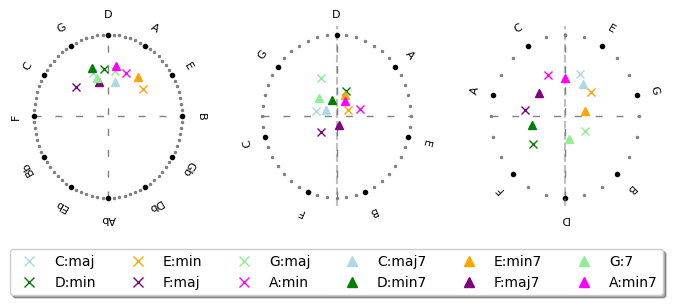

In [43]:
import mir_eval
import pitchspace
import utils
import matplotlib.pyplot as plt

classifier = pitchspace.CPSS_Classifier("/home/max/ET-TI/Masterarbeit/chord-recognition/models/cpss/cpss_sevenths.npy",alphabet="sevenths")


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = []
def getColor(chordlabel):
    colors = ["lightblue","blue", "green", "red", "orange", "purple", "grey", "lightgreen","brown", "magenta", "teal","cyan","white"]
    root,_,_ = mir_eval.chord.encode(chordlabel)
    return colors[root]

key_index = 0
# chordmodel in the key of C
fig,ax =plt.subplots(1,3,figsize=(8,7/3))
utils.plotCircleF(ax[0])
utils.plotCircleFR(ax[1],pitch_class_index=key_index)
utils.plotCircleTR(ax[2],pitch_class_index=key_index)
marker="x" # triads 
for i,x in enumerate(classifier._model[key_index]):
    if i == 6: 
        marker="^" # tetrads
    color = getColor(classifier._labels[x._index])
    ax[0].plot(x._mu[0],x._mu[1],marker=marker,color=color)
    ax[1].plot(x._mu[2],x._mu[3],marker=marker,color=color)
    ax[2].plot(x._mu[4],x._mu[5],marker=marker,color=color)
    legend_elements.append(Line2D([], [], marker=marker,linestyle='None', color=color, label=classifier._labels[x._index],
                     markersize=7))
ax[1].legend(handles=legend_elements,loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=6,facecolor="white")
plt.subplots_adjust(wspace=0.3)
fig.savefig("../latex/figures/cpss_model_c_means.png",bbox_inches='tight')

### Bigram Analysis

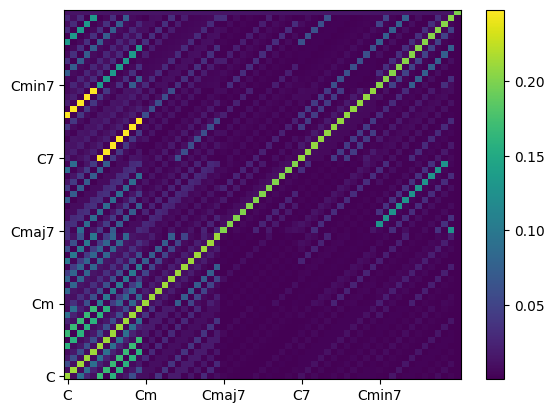

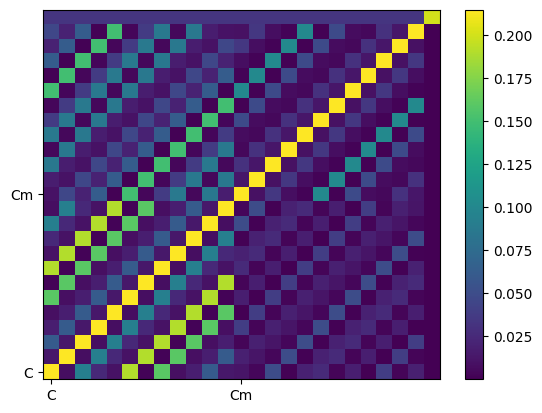

In [5]:
import numpy as np
import matplotlib.pyplot as plt

fixed_state_transition = True


if fixed_state_transition:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/sevenths_20.npy")
else:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/A_sevenths.npy")
fig,ax = plt.subplots()
img = ax.imshow(A,origin="lower",aspect="auto")
ticklabels = ["C","Cm","Cmaj7","C7","Cmin7"]
ticks= np.arange(0,60,12)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar(img);

if fixed_state_transition:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/majmin_20.npy")  
else:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/A_majmin.npy")  
fig,ax = plt.subplots()
img = ax.imshow(A,origin="lower",aspect="auto")
ticklabels = ["C","Cm"]
ticks= np.arange(0,24,12)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar(img);

# Transcription Results

In [1]:
import visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.ioff();
visualization.visualizationApp("../results/");


### DREAM MAGIC
|eval-scheme| f-score| WSCR| Segmentation |
| --- | --- |--- |--- |
|majmin|73.00|73.00|73.00|
|sevenths|62.00|54.00|73.00|


## DEEP CHROMA EXPERIMENT
The chromagram obtained from the deep chroma extractor, was used instead of the CRP feature in this experiment </br>


----------dcp_pitchspace.hdf5------------
 & beatles &rwc\_pop & rw &queen &combined \\
CPSS & 0.80$\pm$0.11 &0.79$\pm$0.10 &0.81$\pm$0.14 &0.76$\pm$0.17 &0.80$\pm$0.11 \\
HMM & 0.83$\pm$0.10 &0.82$\pm$0.10 &0.86$\pm$0.12 &0.79$\pm$0.18 &0.83$\pm$0.11 \\
DCP & 0.85$\pm$0.09 &0.84$\pm$0.09 &0.86$\pm$0.11 &0.80$\pm$0.21 &0.85$\pm$0.10 \\

 & beatles &rwc\_pop & rw &queen &combined \\
CPSS & 0.76$\pm$0.18 &0.70$\pm$0.18 &0.78$\pm$0.15 &0.69$\pm$0.16 &0.74$\pm$0.18 \\
HMM & 0.80$\pm$0.17 &0.68$\pm$0.28 &0.83$\pm$0.15 &0.70$\pm$0.22 &0.77$\pm$0.19 \\
DCP & 0.80$\pm$0.16 &0.71$\pm$0.27 &0.83$\pm$0.14 &0.73$\pm$0.20 &0.79$\pm$0.17 \\


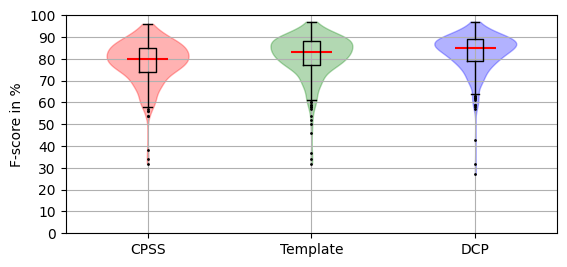

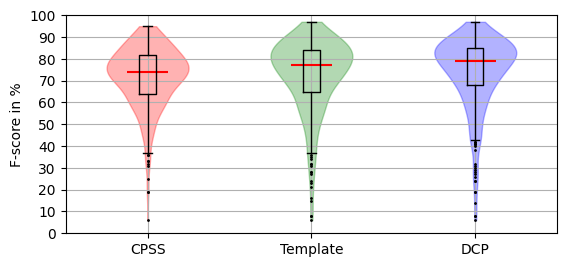

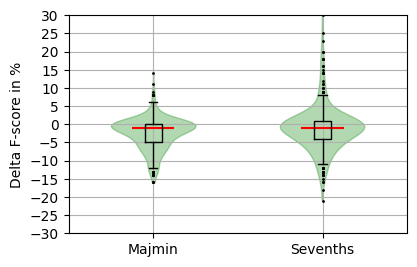

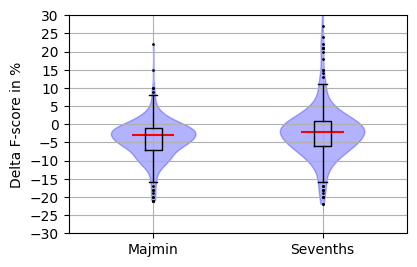

In [1]:
import numpy as np 
import utils

experiment_number = 4  # choose from 1 to 4
experiments = {1:"crp_pitchspace_no_key.hdf5", 2:"crp_pitchspace.hdf5",
                3:"dcp_pitchspace_no_key.hdf5",4:"dcp_pitchspace.hdf5"}

def computeStatistics(data):
    median = np.median(data)
    iqr = np.subtract(*np.percentile(data, [75, 25]))
    return median,iqr
# load madmom results
dcp_majmin = utils.getFscoreResults(f"../results/madmom.hdf5","dcp","majmin")
dcp_sevenths = utils.getFscoreResults(f"../results/madmom.hdf5","dcp","sevenths")

model = "cpss"
# model = "templates"

data_majmin = []
data_sevenths = []

# prepare f_scores for violinplots and print table of results
filepath = f"../results/dcp_pitchspace.hdf5"
cpss_majmin = utils.getFscoreResults(filepath,"est_cpss","majmin")
cpss_sevenths = utils.getFscoreResults(filepath,"est_cpss","sevenths")
templates_majmin = utils.getFscoreResults(filepath,"est_templates","majmin")
templates_sevenths = utils.getFscoreResults(filepath,"est_templates","sevenths")
for x,y in zip(dcp_majmin["combined"][1],templates_majmin["combined"][1]):
    if x != y:
        print(x,y)
print(f"----------{experiments[experiment_number]}------------")

cpss_results = "CPSS & "
templ_results = "HMM & " 
dcp_results = "DCP & "
header = " & "
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
    med,iqr = computeStatistics(cpss_majmin[dset][0])
    cpss_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    med,iqr = computeStatistics(templates_majmin[dset][0])
    templ_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"        
    med,iqr = computeStatistics(dcp_majmin[dset][0])
    dcp_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"
header = header[:-1] + "\\\\"
cpss_results = cpss_results[:-1]+ "\\\\"
templ_results = templ_results[:-1] + "\\\\"
dcp_results = dcp_results[:-1]  + "\\\\"
print(header)
print(cpss_results)
print(templ_results)
print(dcp_results)
print()

cpss_results = "CPSS & "
templ_results = "HMM & " 
dcp_results = "DCP & "
header = " & "
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
    med,iqr = computeStatistics(cpss_sevenths[dset][0])
    cpss_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    med,iqr = computeStatistics(templates_sevenths[dset][0])
    templ_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"        
    med,iqr = computeStatistics(dcp_sevenths[dset][0])
    dcp_results += f"{med:0.2f}$\\pm${iqr:0.2f} &"
header = header[:-1] + "\\\\"
cpss_results = cpss_results[:-1]+ "\\\\"
templ_results = templ_results[:-1] + "\\\\"
dcp_results = dcp_results[:-1]  + "\\\\"
print(header)
print(cpss_results)
print(templ_results)
print(dcp_results)
data_majmin.append([100*f for f in cpss_majmin["combined"][0]])
data_majmin.append([100*f for f in templates_majmin["combined"][0]])
data_majmin.append([100*f for f in dcp_majmin["combined"][0]])
data_sevenths.append([100*f for f in cpss_sevenths["combined"][0]])
data_sevenths.append([100*f for f in templates_sevenths["combined"][0]])
data_sevenths.append([100*f for f in dcp_sevenths["combined"][0]])
colors = ['r','g','b']
xlabels = ["CPSS","Template","DCP"]
fig,ax = utils.plotResults(data_majmin,xlabels,colors,np.arange(0,110,10),ylim=(0,100))
ax.set_ylabel("F-score in %")
fig.savefig("../latex/figures/deepchroma_f_majmin.png")
fig,ax = utils.plotResults(data_sevenths,xlabels,colors,np.arange(0,110,10),ylim=(0,100));
ax.set_ylabel("F-score in %")
fig.savefig("../latex/figures/deepchroma_f_sevenths.png")
# compare CPSS with Templates
deltas_majmin = [x-y for x,y in zip(data_majmin[0],data_majmin[1])]
deltas_sevenths = [x-y for x,y in zip(data_sevenths[0],data_sevenths[1])]
colors = ['g','g']
xlabels = ["Majmin","Sevenths"]
fig,ax = utils.plotResults([deltas_majmin,deltas_sevenths],xlabels,colors,np.arange(-30,40,5),ylim=(-30,30),figsize=(4,2.5));
fig.savefig("../latex/figures/deepchroma_delta_templates.png")
# compare CPSS with DeepChroma
deltas_majmin = [x-y for x,y in zip(data_majmin[0],data_majmin[2])]
deltas_sevenths = [x-y for x,y in zip(data_sevenths[0],data_sevenths[2])]
colors = ['b','b']
xlabels = ["Majmin","Sevenths"]
fig,ax = utils.plotResults([deltas_majmin,deltas_sevenths],xlabels,colors,np.arange(-30,40,5),ylim=(-30,30),figsize=(4,2.5));
fig.savefig("../latex/figures/deepchroma_delta_dcp.png")

Comparison of Stable regions transcribed with CPSS and with Template based approach </br>
delta = f_score_pitchspace - f_score_template

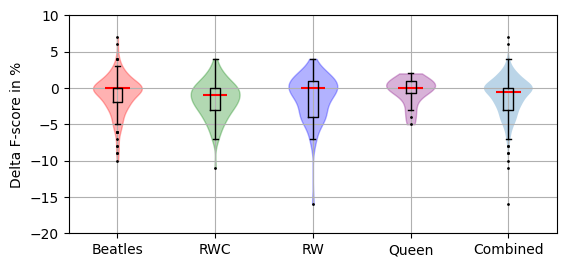

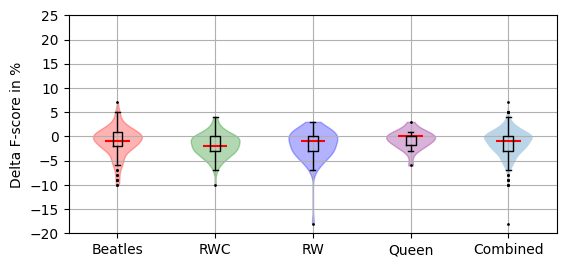

In [9]:
experiment_number = 1   # choose from 1 to 4

# STABLE REGIONS
filepath = f"../results/crp_pitchspace.hdf5"

stable_cpss_majmin = utils.getFscoreResults(filepath,"stable_cpss","majmin")
stable_cpss_sevenths = utils.getFscoreResults(filepath,"stable_cpss","sevenths")
stable_templates_majmin =  utils.getFscoreResults(filepath,"stable_templates","majmin")
stable_templates_sevenths =  utils.getFscoreResults(filepath,"stable_templates","sevenths")

deltas_majmin = []
deltas_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    deltas_majmin.append([100*(x-y) for x,y in zip(stable_cpss_majmin[dset][0],stable_templates_majmin[dset][0])])
    deltas_sevenths.append([100*(x-y) for x,y in zip(stable_cpss_sevenths[dset][0],stable_templates_sevenths[dset][0])])

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]

utils.plotResults(deltas_majmin,xlabels,colors)
utils.plotResults(deltas_sevenths,xlabels,colors,yticks=np.arange(-20,30,5),ylim=(-20,25));

Comparison of Template based approach with the hybrid model

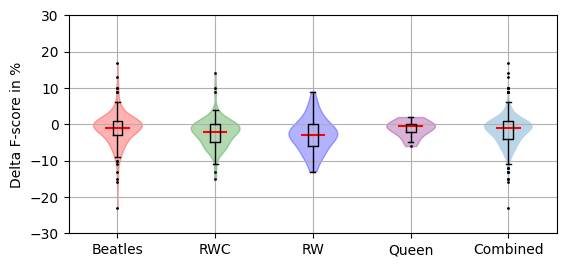

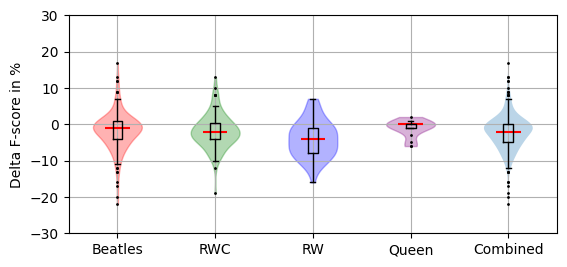

In [11]:
# STABLE REGIONS
stable_cpss_majmin = utils.getFscoreResults(filepath,"est_cpss","majmin")
stable_cpss_sevenths =  utils.getFscoreResults(filepath,"est_cpss","sevenths")
stable_templates_majmin =   utils.getFscoreResults(filepath,"est_templates","majmin")
stable_templates_sevenths =   utils.getFscoreResults(filepath,"est_templates","sevenths")

deltas_majmin = []
deltas_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    deltas_majmin.append([100*(x-y) for x,y in zip(stable_cpss_majmin[dset][0],stable_templates_majmin[dset][0])])
    deltas_sevenths.append([100*(x-y) for x,y in zip(stable_cpss_sevenths[dset][0],stable_templates_sevenths[dset][0])])

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]

fig,ax = utils.plotResults(deltas_majmin,xlabels,colors)
ax.set_yticks(np.arange(-30,40,10))
ax.set_ylim(-30,30);
fig,ax = utils.plotResults(deltas_sevenths,xlabels,colors);
ax.set_yticks(np.arange(-30,40,10))
ax.set_ylim(-30,30);

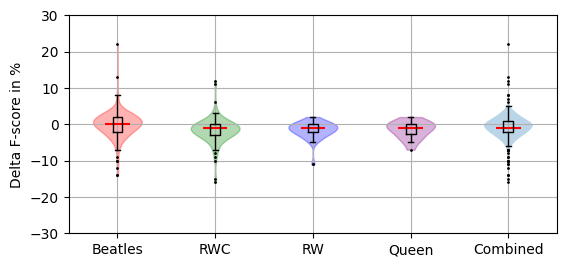

In [2]:
# STABLE REGIONS
filepath = "../results/source_separation_none"
none_majmin = utils.getFscoreResults(filepath,None,"majmin")
filepath = "../results/source_separation_drums"
drums_majmin =  utils.getFscoreResults(filepath,None,"majmin")
deltas_majmin = []
deltas_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    deltas_majmin.append([100*(x-y) for x,y in zip(none_majmin[dset][0],drums_majmin[dset][0])])

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]

fig,ax = utils.plotResults(deltas_majmin,xlabels,colors)
ax.set_yticks(np.arange(-30,40,10))
ax.set_ylim(-30,30);
